In [249]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))
SEED = 42
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

Populating the interactive namespace from numpy and matplotlib


In [133]:
## test 1 image
image = cv2.imread('a3_45.png')
image.shape

(750, 7522, 3)

In [102]:
image[0][0]   # top-left, first pixel is white
# [255, 255, 255] = white
# [0, 0, 0] = black
# [255, 0, 0] = blue
# [0, 128, 0] = green/olive

array([255, 255, 255], dtype=uint8)

In [103]:
image[749][7521]   # bottom-right, last pixel is also white

array([255, 255, 255], dtype=uint8)

Time taken: 90.3 seconds


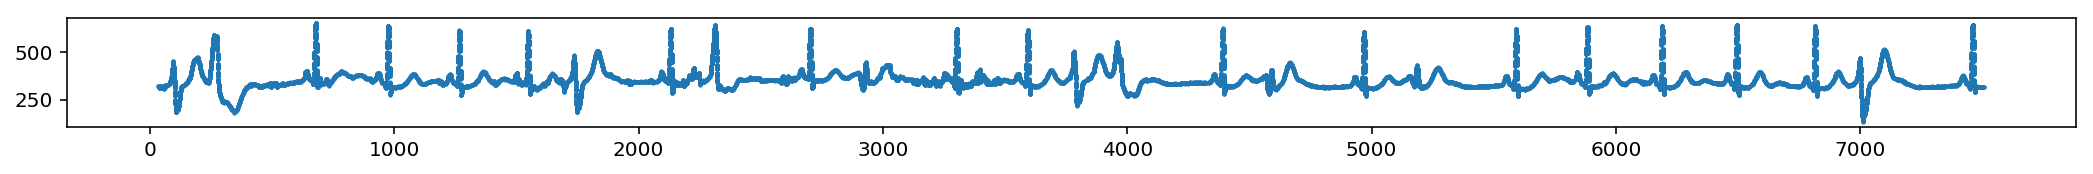

In [134]:
# to extract black pixel from the entire image, 7522 x 750 pixel
time1 = time.time() 
x_list, y_list = [], []

for x in np.arange(0, 7522, 1):
    for y in np.arange(0, 750, 1):
        if np.all(image[y][x] == (0, 0, 0)):   # black
            x_list.append(x)
            y_list.append(750-y)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))

show_graph(x_list, y_list, 18, 1)

In [ ]:
# to locate position of "V" (green/olive color)
position_list = []
x=100   # start position, not too close to left boundary
while x<7422:   # end position, not too close to right boundary
    if np.all(image[45][x] == (0, 128, 0)):
        position_list.append(x)
        x += 25
    x += 1

print('Number of V-beat found: ', len(position_list))

# to extract data points for V-beat graph
# to iterate for position[i]
i = 0
x_list, y_list = [0], [0]   # boundary condition
begin = position_list[i]-65
end = position_list[i]+85
for x in np.arange(begin, end, 1):
    x_list.append(x-begin)
    for y in np.arange(0, 750, 1):
        if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
            y_list.append(750-y)
            break
        if y==749:   # if there is no black dot in the column, append previous point
            y_list.append(y_list[x-begin-1])
x_list.pop(0)   # remove boundary condition
y_list.pop(0)   # remove boundary condition
print(len(x_list), x_list)
print(y_list)
show_graph(x_list, y_list, 2, 5)

i = 2
x_list, y_list = [0], [0]   # boundary condition
begin = position_list[i]-65
end = position_list[i]+85
for x in np.arange(begin, end, 1):
    x_list.append(x-begin)
    for y in np.arange(0, 750, 1):
        if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
            y_list.append(750-y)
            break
        if y==749:   # if there is no black dot in the column, append previous point
            y_list.append(y_list[x-begin-1])
x_list.pop(0)   # remove boundary condition
y_list.pop(0)   # remove boundary condition
print(len(x_list), x_list)
print(y_list)
show_graph(x_list, y_list, 2, 5)

In [ ]:
# to locate position of "N" (blue color)
position_list = []
x=100   # start position, not too close to left boundary
while x<7422:   # end position, not too close to right boundary
    if np.all(image[45][x] == (255, 0, 0)):   # (blue color)
        position_list.append(x)
        x += 25
    x += 1

print('Number of N found: ', len(position_list))

# to extract data points for N graph
# to iterate for position[i]
i = 0
x_list, y_list = [0], [0]   # boundary condition
begin = position_list[i]-65
end = position_list[i]+85
for x in np.arange(begin, end, 1):
    x_list.append(x-begin)
    for y in np.arange(0, 750, 1):
        if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
            y_list.append(750-y)
            break
        if y==749:   # if there is no black dot in the column, append previous point
            y_list.append(y_list[x-begin-1])
x_list.pop(0)   # remove boundary condition
y_list.pop(0)   # remove boundary condition
print(len(x_list), x_list)
print(y_list)
show_graph(x_list, y_list, 2, 5)

In [ ]:
# to locate position of "N" (blue color)

x_list, y_list = [], []
y=45
x=100   # start position, not too close to left boundary
while x<7422:   # end position, not too close to right boundary
    if np.all(image[y][x] == (255, 0, 0)):
        x_list.append(x)
        y_list.append(750-y)
        x += 25
    x += 1

plt.figure(figsize = [18,1])   # [width, height]
plt.scatter(x_list, y_list)

In [264]:
# # grab the image paths and randomly shuffle them
# imagePaths = sorted(list(paths.list_images('try')))
# random.seed(SEED)
# random.shuffle(imagePaths)
# imagePaths   # ['try\\a3_45.png', 'try\\a1_0.png', 'try\\a4_80.png', 'try\\a6_83.png']

['try\\a3_45.png', 'try\\a1_0.png', 'try\\a4_80.png', 'try\\a6_83.png']

In [ ]:
## to plot graph using x_list and y_list
def show_graph(x_list, y_list, width, height):
    plt.figure(figsize = [width, height])   # [width, height]
    plt.scatter(x_list, y_list, marker='.', s=5)
    plt.show()
    return 

## to locate position of "V" (olive) or "N" (blue) or "?-mark" (blue)
def locate_pos(image, y_level, color):
    position_list = []
    x=100   # start position, not too close to left boundary
    while x<7422:   # end position, not too close to right boundary
        if np.all(image[y_level][x] == color):
            position_list.append(x)
            x += 25
        x += 1
    return position_list

In [ ]:
## to extract y-coordinates for x = 0 to 150
def extract_y_coord():


In [251]:
# pre-processing for TRAIN dataset
time1 = time.time()
train_X = []
train_y = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('train')))
random.seed(SEED)
random.shuffle(imagePaths)

# loop over the input images
image_count = 0
for imagePath in imagePaths:
    image_count+=1
    image = cv2.imread(imagePath)
    
    ## (A) to locate position of "V" (green/olive color)
    y_level = 45
    position_list = locate_pos(image, y_level, (0, 128, 0))   # (green/olive color)
    while len(position_list) == 0 and y_level < 100:
        y_level+=5
        position_list = locate_pos(image, y_level, (0, 128, 0))    
    count = len(position_list)
    print('\nNumber of V-beat found: ', count)

    if count > 0:   # to extract data points for V-beat
        for i in range(count):   # to iterate for position[i]
            x_list, y_list = [0], [0]   # boundary condition
            begin = position_list[i]-70
            end = position_list[i]+80
            for x in np.arange(begin, end, 1):
#                 x_list.append(x-begin)
                for y in np.arange(0, 750, 1):
                    if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
                        y_list.append(750-y)
                        break
                    if y==749:   # if there is no black dot in the column, append previous point
                        y_list.append(y_list[x-begin-1])
#             x_list.pop(0)   # remove boundary condition
            y_list.pop(0)   # remove boundary condition

            train_X.append( y_list )
            train_y.append( 1 )
            print('V', i, end=', ')
#             show_graph(x_list, y_list, 2, 2)

    ## (B) to locate position of "N" (blue color)
    y_level = 45
    position_list = locate_pos(image, y_level, (255, 0, 0))   # (blue color)
    while len(position_list) == 0 and y_level < 100:
        y_level+=5
        position_list = locate_pos(image, y_level, (255, 0, 0))  

    if len(position_list) < count:   # N usually more than V-beat
        count = len(position_list)
    else:   # to extract data points for N
        for i in range(count):   # to iterate for position[i]
            x_list, y_list = [0], [0]   # boundary condition
            begin = position_list[i]-70
            end = position_list[i]+80
            for x in np.arange(begin, end, 1):
#                 x_list.append(x-begin)
                for y in np.arange(0, 750, 1):
                    if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
                        y_list.append(750-y)
                        break
                    if y==749:   # if there is no black dot in the column, append previous point
                        y_list.append(y_list[x-begin-1])
#             x_list.pop(0)   # remove boundary condition
            y_list.pop(0)   # remove boundary condition

            train_X.append( y_list )
            train_y.append( 0 )
            print('N', i, end=', ')
#             show_graph(x_list, y_list, 2, 2)

print('\nTotal images processed: ', image_count)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))


Number of V-beat found:  10
V 0, V 1, V 2, V 3, V 4, V 5, V 6, V 7, V 8, V 9, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, N 8, N 9, 
Number of V-beat found:  1
V 0, N 0, 
Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  0

Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  0

Number of V-beat found:  4
V 0, V 1, V 2, V 3, N 0, N 1, N 2, N 3, 
Number of V-beat found:  0

Number of V-beat found:  7
V 0, V 1, V 2, V 3, V 4, V 5, V 6, N 0, N 1, N 2, N 3, N 4, N 5, N 6, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  5
V 0, V 1, V 2, V 3, V 4, N 0, N 1, N 2, N 3, N 4, 
Number of V-beat found:  2
V 0, V 1, N 0, N 1, 
Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  0

Number of V-beat found:  1
V 0, N 0, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat fou

V 0, V 1, V 2, V 3, V 4, V 5, V 6, V 7, V 8, V 9, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, N 8, N 9, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  7
V 0, V 1, V 2, V 3, V 4, V 5, V 6, N 0, N 1, N 2, N 3, N 4, N 5, N 6, 
Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  1
V 0, N 0, 
Number of V-beat found:  0

Number of V-beat found:  4
V 0, V 1, V 2, V 3, N 0, N 1, N 2, N 3, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  2
V 0, V 1, N 0, N 1, 
Number of V-beat found:  1
V 0, N 0, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat fo

V 0, N 0, 
Number of V-beat found:  2
V 0, V 1, N 0, N 1, 
Number of V-beat found:  0

Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  2
V 0, V 1, N 0, N 1, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  7
V 0, V 1, V 2, V 3, V 4, V 5, V 6, N 0, N 1, N 2, N 3, N 4, N 5, N 6, 
Number of V-beat found:  0

Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  5
V 0, V 1

V 0, V 1, V 2, V 3, V 4, V 5, V 6, V 7, V 8, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, N 8, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  4
V 0, V 1, V 2, V 3, N 0, N 1, N 2, N 3, 
Number of V-beat found:  2
V 0, V 1, N 0, N 1, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  2
V 0, V 1, N 0, N 1, 
Number of V-beat found:  8
V 0, V 1, V 2, V 3, V 4, V 5, V 6, V 7, N 0, N 1, N 2, N 3, N 4, N 5, N 6, N 7, 
Number of V-beat found:  7
V 0, V 1, V 2, V 3, V 4, V 5, V 6, N 0, N 1, N 2, N 3, N 4, N 5, N 6, 
Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  0

Number of V-beat found:  3
V 0, V 1, V 2, N 0, N 1, N 2, 
Number of V-beat found:  0

Number of V-beat found:  0

Total images processed:  540
Time taken: 1223.4 seconds


In [252]:
print(len(train_X))
print(len(train_y))

2043
2043


In [263]:
df = pd.DataFrame()
df['X'] = train_X
df['y'] = train_y
df

,X,y
0,"[0, 0, 0, 0, 407, 405, 402, 398, 393, 390, 389...",1
1,"[440, 439, 436, 432, 428, 426, 428, 427, 424, ...",1
2,"[425, 0, 425, 421, 416, 410, 407, 406, 406, 40...",1
3,"[0, 445, 443, 440, 443, 440, 437, 436, 432, 42...",1
4,"[440, 438, 435, 431, 435, 424, 421, 418, 413, ...",1
5,"[425, 419, 418, 420, 420, 417, 412, 417, 405, ...",1
6,"[437, 433, 428, 425, 422, 422, 422, 419, 415, ...",1
7,"[456, 451, 447, 447, 447, 447, 447, 444, 440, ...",1
8,"[0, 361, 0, 361, 0, 359, 358, 358, 356, 352, 3...",1
9,"[0, 381, 378, 375, 371, 368, 366, 368, 367, 36...",1


In [266]:
df['y'].value_counts()

1    1113
0     930
Name: y, dtype: int64

In [264]:
df.to_csv('train_dataset.csv', index=False)

# df = pd.read_csv('train_dataset.csv')
# X, y = df.drop('Y',axis=1), df['Y']

In [270]:
X

array([[  0,   0,   0, ..., 244, 243, 244],
       [440, 439, 436, ..., 267, 261, 260],
       [425,   0, 425, ..., 274, 272, 268],
       ...,
       [254, 256, 259, ..., 256, 255, 256],
       [  0, 244, 242, ..., 242, 245, 246],
       [254,   0, 254, ..., 254, 255, 254]])

In [253]:
X = np.array(train_X)
print(len(X))
y = np.array(train_y)
print(len(y))

2043
2043


In [254]:
# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Test set: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    global model_f1, model_auc, model_ll, model_roc_auc
    model_f1 = f1_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('roc_auc_score')
    plt.show()
  
    return

X_train (1634, 150)
y_train (1634,)
X_test (409, 150)
y_test (409,)



"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.9947, 0.9947, 0.9947, 0.9947, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, 0.9941, optimal cv F1 score = 0.9947
optimal value of C = 0.001

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.8889,  0.100->0.9958,  0.200->1.0000,  0.300->1.0000,  0.400->1.0000,  0.500->0.9979,  0.600->0.9957,  0.700->0.9957,  0.800->0.9957,  0.900->0.9957,  1.000->0.8051,  
Looping decimal place 2
0.100->0.9958,  0.110->0.9958,  0.120->0.9958,  0.130->0.9958,  0.140->0.9979,  0.150->0.9979,  0.160->0.9979,  0.170->0.9979,  0.180->0.9979,  0.190->0.9979,  0.200->1.0000,  0.210->1.0000,  0.220->1.0000,  0.230->1.0000,  0.240->1.0000,  0.250->1.0000,  0.260->1.0000,  0.270->1.0000,  0.280->1.000

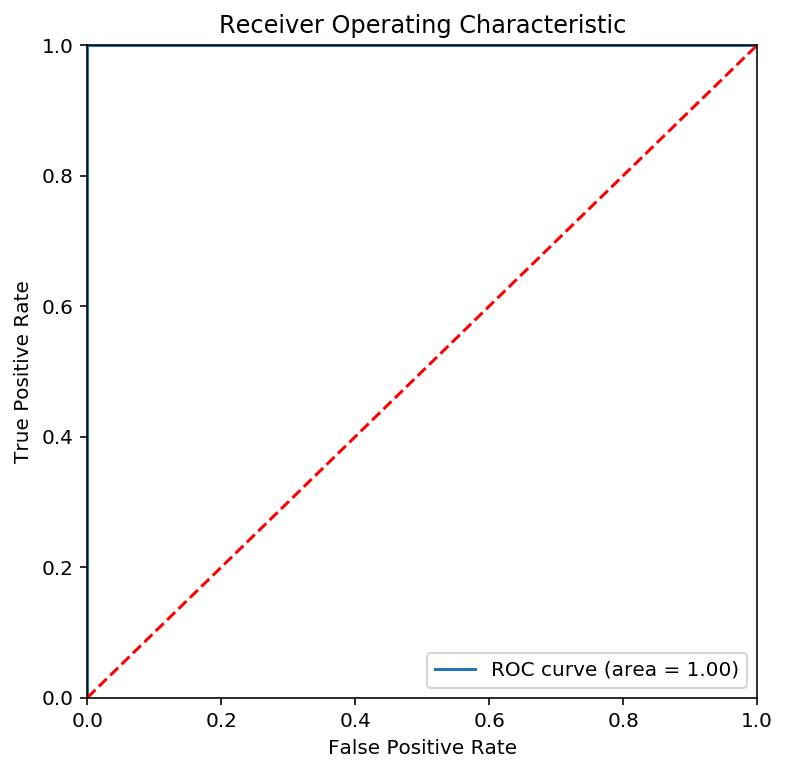

In [257]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,20)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
# logit = LogisticRegression(C = 0.5)
model_report('LogisticRegression', logit)

In [269]:
import seaborn as sns
sns.set()

# see how logistic regression confusion matrix varies with threshold
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (logit.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['N', 'V-beat'],
           yticklabels=['N', 'V-beat']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
logit = LogisticRegression(C = optimal_c)
logit.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(logit, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
# # save the model to disk
# pickle.dump(logit, open('logistic_model.sav', 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open('logistic_model.sav', 'rb'))

In [258]:
# pre-processing for TEST data set
time1 = time.time()
filename_list = []
location_list = []

# grab the image paths (no need shuffle)
imagePaths = sorted(list(paths.list_images('test')))

# loop over the input images
image_count = 0
for imagePath in imagePaths:
    print(imagePath)
    image_count+=1
    image = cv2.imread(imagePath)
    filename_list.append(imagePath)
    
    # to locate position of "?-mark" (blue color)
    y_level = 55
    position_list = locate_pos(image, y_level, (255, 0, 0))   # (blue color)
    while len(position_list) == 0 and y_level < 100:
        y_level+=2
        position_list = locate_pos(image, y_level, (255, 0, 0))
    count = len(position_list)
    print('Number of ?-mark found: ', count)

    # to extract data points 
    test_X = []
    y_pred = []
    if count > 0:
        for i in range(count):   # to iterate for position[i]
            x_list, y_list = [0], [0]   # boundary condition
            begin = position_list[i]-70
            end = position_list[i]+80
            for x in np.arange(begin, end, 1):
#                 x_list.append(x-begin)
                for y in np.arange(0, 750, 1):
                    if np.all(image[y][x] == (0, 0, 0)):   # look for black dot
                        y_list.append(750-y)
                        break
                    if y==749:   # if there is no black dot in the column, append previous point
                        y_list.append(y_list[x-begin-1])
#             x_list.pop(0)   # remove boundary condition
            y_list.pop(0)   # remove boundary condition

            test_X.append( y_list )
            print(i, end=', ')
            # show_graph(x_list, y_list, 2, 2)

        y_pred = logit.predict(test_X)   # default threshold 0.5
        print("\n", y_pred)

    timing_list = []
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            timing_list.append( (round((position_list[i]-36)*(20/7450), 1)) )
    print(timing_list)
    location_list.append(timing_list)

print('\nTotal images processed: ', image_count)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))

test\b1_00.png
Number of ?-mark found:  27
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
[0.4, 1.2, 2.0, 2.9, 3.8, 4.6, 5.4, 6.2, 6.9, 7.8, 8.6, 9.4, 10.3, 11.1, 11.9, 12.6, 13.4, 13.9, 15.1, 15.6, 16.1, 16.9, 17.5, 18.4, 19.0]
test\b1_01.png
Number of ?-mark found:  24
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
 [1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1]
[0.5, 1.7, 2.2, 3.2, 3.8, 4.7, 5.3, 6.3, 6.9, 8.6, 9.5, 10.1, 11.6, 12.6, 13.2, 14.4, 15.2, 16.1, 17.6, 18.5, 19.5]
test\b1_02.png
Number of ?-mark found:  30
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
 [0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1]
[3.8, 3.9, 4.7, 5.2, 5.4, 5.6, 7.1, 11.8, 15.1, 15.9, 19.7]
test\b1_03.png
Number of ?-mark found:  24
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.6, 1.6, 2.2, 3.2, 4.0, 4.9, 5.7, 6.7, 7.6, 8.4, 9.2, 9.8, 10.9, 11.4, 12.6, 13.5, 14.3, 15.0, 15.6, 16.7, 17.6, 18.4, 19.3]
test\b1_29.png
Number of ?-mark found:  23
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.9, 1.7, 2.5, 3.4, 4.2, 4.8, 6.0, 6.6, 7.6, 8.5, 9.4, 10.2, 11.1, 11.9, 12.7, 13.5, 14.3, 15.2, 16.1, 16.9, 17.8, 18.6, 19.4]
test\b1_30.png
Number of ?-mark found:  23
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1.0, 1.9, 2.7, 3.6, 4.5, 5.3, 5.8, 6.9, 7.9, 8.9, 9.4, 10.5, 11.1, 12.2, 12.7, 13.7, 14.0, 14.6, 15.8, 16.7, 17.6, 18.5, 19.4]
test\b1_31.png
Number of ?-mark found:  23
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
 [1 1 1 1

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.5, 1.5, 2.4, 3.3, 4.2, 5.1, 5.9, 6.8, 7.7, 8.7, 9.7, 10.5, 11.3, 12.1, 13.1, 13.6, 15.0, 15.9, 16.7, 17.5, 18.4, 19.4]
test\b1_57.png
Number of ?-mark found:  22
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 
 [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1]
[0.3, 1.0, 2.1, 2.6, 3.8, 4.7, 5.6, 6.5, 7.5, 8.4, 9.2, 10.9, 11.9, 12.9, 13.8, 14.7, 15.5, 16.4, 17.4, 19.5]
test\b1_58.png
Number of ?-mark found:  20
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.4, 1.2, 1.9, 3.0, 4.0, 5.1, 6.0, 6.9, 7.8, 8.7, 9.7, 10.9, 12.0, 13.0, 13.8, 14.8, 15.8, 16.9, 18.1, 19.0]
test\b1_59.png
Number of ?-mark found:  21
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.7, 1.7, 2.7, 3.8, 4.8, 5.6, 6.6, 7.6, 8.

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
 [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
[0.6, 1.4, 2.2, 3.1, 4.0, 4.9, 5.8, 6.6, 7.4, 8.3, 10.1, 10.8, 11.9, 12.6, 13.5, 14.3, 14.9, 16.1, 16.9, 17.8, 18.6, 19.5]
test\b1_88.png
Number of ?-mark found:  24
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
 [1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
[0.2, 1.0, 1.9, 2.8, 3.7, 4.4, 5.3, 7.0, 7.9, 8.8, 9.6, 10.2, 11.2, 12.8, 13.7, 14.6, 15.4, 16.3, 16.8, 17.9, 18.4, 19.5]
test\b1_89.png
Number of ?-mark found:  22
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1.2, 2.0, 2.8, 3.7, 4.5, 5.4, 6.0, 7.2, 8.1, 8.9, 9.7, 10.6, 11.5, 12.0, 13.2, 14.1, 14.7, 15.8, 16.7, 17.6, 18.2, 19.4]
test\b2_00.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1]
[0.6, 1.2, 1.8, 3.0, 3.6, 4.2, 5.3, 5.9, 6.5, 6.9, 7.7, 8.3, 8.9, 10.0, 10.6, 11.2, 12.4, 13.0, 13.6, 14.8, 15.4, 16.0, 16.4, 17.2, 17.8, 18.4, 18.7, 19.6]
test\b2_19.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
[0.7, 1.9, 2.5, 3.1, 3.4, 4.3, 4.9, 5.5, 5.9, 6.7, 7.3, 7.9, 8.2, 9.1, 9.7, 10.2, 11.4, 12.0, 12.6, 13.8, 14.4, 15.0, 16.2, 16.8, 17.4, 18.6, 19.2, 19.8]
test\b2_20.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1]
[0.3, 0.9, 1.4, 2.1, 2.7, 3.

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
[0.3, 0.9, 1.5, 2.1, 2.7, 3.2, 3.8, 4.4, 4.9, 6.1, 6.5, 7.2, 7.8, 8.4, 8.9, 9.4, 10.2, 10.8, 11.4, 12.0, 12.5, 13.7, 14.3, 14.8, 15.3, 16.0, 16.5, 17.1, 17.7, 18.3, 19.5]
test\b2_40.png
Number of ?-mark found:  34
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 
 [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.6, 1.1, 1.7, 2.3, 2.9, 3.4, 4.0, 4.6, 5.7, 6.3, 6.9, 7.4, 8.0, 8.6, 9.2, 10.3, 10.8, 11.5, 12.0, 12.6, 13.2, 13.8, 14.3, 15.0, 15.6, 15.9, 16.7, 17.3, 17.9, 18.5, 19.1, 19.6]
test\b2_41.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
[0.6, 1.2, 1.8, 2.4, 2.9, 3.5, 4.1, 4.6, 5.2, 6.4, 6.9, 7.5, 8.7, 9.1, 9.9, 10.5, 11.1, 11.7, 12.1, 12.8, 13.4, 14.0, 14.4, 15.2, 15.8, 16.4, 17.0, 17.5, 18.7, 19.3]
test\b2_61.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1]
[1.0, 1.6, 2.2, 3.3, 3.8, 4.5, 5.1, 5.7, 6.3, 7.4, 8.0, 8.6, 9.8, 10.4, 11.0, 12.2, 12.6, 13.4, 14.0, 14.6, 15.0, 16.3, 16.8, 17.2, 18.1, 18.7, 19.3]
test\b2_62.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
[0.4, 1.5, 2.1, 2.7, 3

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1]
[0.7, 1.4, 1.9, 3.1, 3.7, 4.3, 5.5, 6.1, 6.7, 7.9, 8.5, 9.1, 10.3, 10.9, 11.5, 12.7, 13.3, 13.9, 15.0, 15.6, 16.2, 17.4, 18.0, 18.6, 19.8]
test\b2_82.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1]
[0.3, 0.9, 2.1, 2.7, 3.3, 4.5, 5.1, 5.7, 6.5, 7.4, 7.9, 8.6, 9.1, 9.8, 10.4, 11.0, 11.6, 12.2, 12.8, 13.4, 14.6, 15.1, 16.3, 17.0, 17.5, 18.7, 19.3]
test\b2_83.png
Number of ?-mark found:  33
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 
 [0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1]
[1.0, 1.6, 2.2, 3.4, 4.0, 4.6, 5.8, 6.4, 7.0, 8.1,

In [259]:
len(location_list)

180

In [260]:
len(filename_list)

180

In [261]:
# create pandas dataframe from lists using dictionary
df = pd.DataFrame()
df['filename'] = filename_list
df['location(sec)'] = location_list
df

,filename,location(sec)
0,test\b1_00.png,"[0.4, 1.2, 2.0, 2.9, 3.8, 4.6, 5.4, 6.2, 6.9, ..."
1,test\b1_01.png,"[0.5, 1.7, 2.2, 3.2, 3.8, 4.7, 5.3, 6.3, 6.9, ..."
2,test\b1_02.png,"[3.8, 3.9, 4.7, 5.2, 5.4, 5.6, 7.1, 11.8, 15.1..."
3,test\b1_03.png,"[0.9, 2.7, 3.3, 4.5, 5.4, 6.2, 6.7, 7.8, 8.4, ..."
4,test\b1_04.png,"[0.4, 1.3, 2.1, 2.7, 3.8, 4.6, 5.4, 6.2, 7.1, ..."
5,test\b1_05.png,"[0.2, 1.3, 1.7, 1.9, 3.0, 3.6, 4.9, 5.6, 6.9, ..."
6,test\b1_06.png,"[1.0, 2.1, 3.1, 4.1, 4.9, 5.8, 6.7, 7.6, 8.5, ..."
7,test\b1_07.png,"[0.3, 1.2, 2.1, 2.9, 3.7, 4.2, 5.3, 5.9, 7.1, ..."
8,test\b1_08.png,"[1.1, 1.9, 2.6, 3.2, 4.3, 6.1, 7.0, 7.7, 8.2, ..."
9,test\b1_09.png,"[0.6, 1.1, 1.6, 2.4, 3.5, 4.4, 5.3, 6.1, 7.0, ..."


In [262]:
df.to_csv('test_results.csv', index=False)